**do not hit run all, as this notebook is divided into two parts**

In this exercise you'll train a neural network on the Fuel Economy dataset and then explore the effect of the learning rate and batch size on SGD.

When you're ready, run this next cell to set everything up!

In [ ]:
!git clone https://github.com/Kaggle/learntools.git

fatal: destination path 'learntools' already exists and is not an empty directory.


In [ ]:
%cd learntools

/content/learntools


In [ ]:
!pip install .

Processing /content/learntools
  Preparing metadata (setup.py) ... done
  Created wheel for learntools: filename=learntools-0.3.4-py3-none-any.whl size=268968 sha256=b465421052d9ada91eb2296f46479829bc56a627503bb4047aafab64cf8fd3c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-jz26pkzz/wheels/bd/49/33/b44d9c96eb0bf023bd3d48634beadc16ae744eb6af3e5f35f4
Successfully built learntools
  Attempting uninstall: learntools
    Found existing installation: learntools 0.3.4
    Uninstalling learntools-0.3.4:
      Successfully uninstalled learntools-0.3.4


In [ ]:
# Setup plotting
import matplotlib.pyplot as plt
from learntools.deep_learning_intro.dltools import animate_sgd
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

<ipython-input-4-69b99e41148c>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In the Fuel Economy dataset your task is to predict the fuel economy of an automobile given features like its type of engine or the year it was made.

First load the dataset by running the cell below.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

fuel = pd.read_csv('https://raw.githubusercontent.com/raoulraft/Network-Intelligence-Course/main/fuel.csv')

fuel.head()
fuel.info()
fuel.describe()

X = fuel.copy()
# Remove target
y = X.pop('FE')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
y = np.log(y) # log transform target instead of standardizing

input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EngDispl             1107 non-null   float64
 1   NumCyl               1107 non-null   int64  
 2   Transmission         1107 non-null   object 
 3   FE                   1107 non-null   float64
 4   AirAspirationMethod  1107 non-null   object 
 5   NumGears             1107 non-null   int64  
 6   TransLockup          1107 non-null   int64  
 7   TransCreeperGear     1107 non-null   int64  
 8   DriveDesc            1107 non-null   object 
 9   IntakeValvePerCyl    1107 non-null   int64  
 10  ExhaustValvesPerCyl  1107 non-null   int64  
 11  CarlineClassDesc     1107 non-null   object 
 12  VarValveTiming       1107 non-null   int64  
 13  VarValveLift         1107 non-null   int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 121.2+ KB
Input shape: [50]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Take a look at the data if you like. Our target in this case is the 'FE' column and the remaining columns are the features.

In [ ]:
# Uncomment to see original data
fuel.head()
# Uncomment to see processed features
pd.DataFrame(X[:10,:]).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.296693,2.120794,0.524148,-1.458464,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Run the next cell to define the network we'll use for this task.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

Before training the network we need to define the loss and optimizer we'll use. Using the model's compile method, add the Adam optimizer and MAE loss.

In [ ]:
model.compile(optimizer='adam',loss='mae')

Once you've defined the model and compiled it with a loss and optimizer you're ready for training. Train the network for 200 epochs with a batch size of 128. The input data is X with target y.

In [ ]:
history = model.fit(
    X, y,
    validation_data=(X, y),
    batch_size=128,
    epochs=200,
)

Epoch 1/200
9/9 [==============================] - 1s 30ms/step - loss: 3.1459 - val_loss: 2.2519
Epoch 2/200
9/9 [==============================] - 0s 8ms/step - loss: 1.4294 - val_loss: 0.7315
Epoch 3/200
9/9 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.3355
Epoch 4/200
9/9 [==============================] - 0s 12ms/step - loss: 0.3319 - val_loss: 0.2622
Epoch 5/200
9/9 [==============================] - 0s 13ms/step - loss: 0.2368 - val_loss: 0.1994
Epoch 6/200
9/9 [==============================] - 0s 16ms/step - loss: 0.1775 - val_loss: 0.1547
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1418 - val_loss: 0.1292
Epoch 8/200
9/9 [==============================] - 0s 9ms/step - loss: 0.1195 - val_loss: 0.1059
Epoch 9/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1036 - val_loss: 0.0981
Epoch 10/200
9/9 [==============================] - 0s 8ms/step - loss: 0.0943 - val_loss: 0.0882
Epoch 11/200
9/9 [======

The last step is to look at the loss curves and evaluate the training. Run the cell below to get a plot of the training loss.

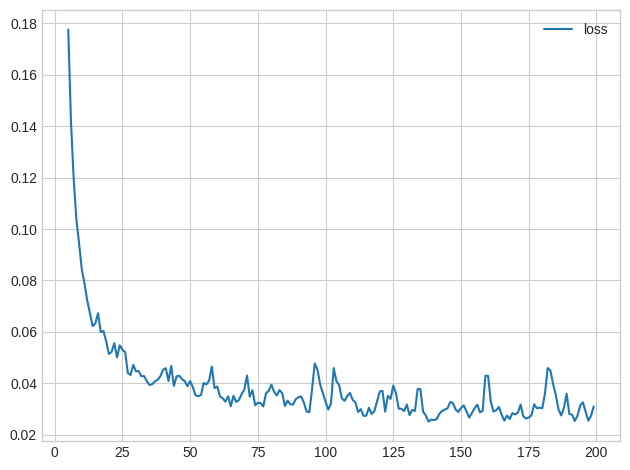

In [ ]:
import pandas as pd

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();

With the learning rate and the batch size, you have some control over:

How long it takes to train a model
How noisy the learning curves are
How small the loss becomes
To get a better understanding of these two parameters, we'll look at the linear model, our ppsimplest neural network. Having only a single weight and a bias, it's easier to see what effect a change of parameter has.

The next cell will generate an animation like the one in the tutorial. Change the values for learning_rate, batch_size, and num_examples (how many data points) and then run the cell. (It may take a moment or two.) Try the following combinations, or try some of your own:

In [ ]:
learning_rate = 0.9
batch_size = 4096
num_examples = 256

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these, if you like
    steps=50, # total training steps (batches seen)
    true_w=3.0, # the slope of the data
    true_b=2.0, # the bias of the data
)

You probably saw that smaller batch sizes gave noisier weight updates and loss curves. This is because each batch is a small sample of data and smaller samples tend to give noisier estimates. Smaller batches can have an "averaging" effect though which can be beneficial.

Smaller learning rates make the updates smaller and the training takes longer to converge. Large learning rates can speed up training, but don't "settle in" to a minimum as well. When the learning rate is too large, the training can fail completely. (Try setting the learning rate to a large value like 0.99 to see this.)

**Now try this with the red-wine dataset!** https://github.com/raoulraft/Network-Intelligence-Course/blob/main/red-wine.csv




**STOP HERE BEFORE CONTINUING**

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras import callbacks

spotify = pd.read_csv('https://raw.githubusercontent.com/raoulraft/Network-Intelligence-Course/main/spotify_dataset.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))



Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

Minimum Validation Loss: 0.1974


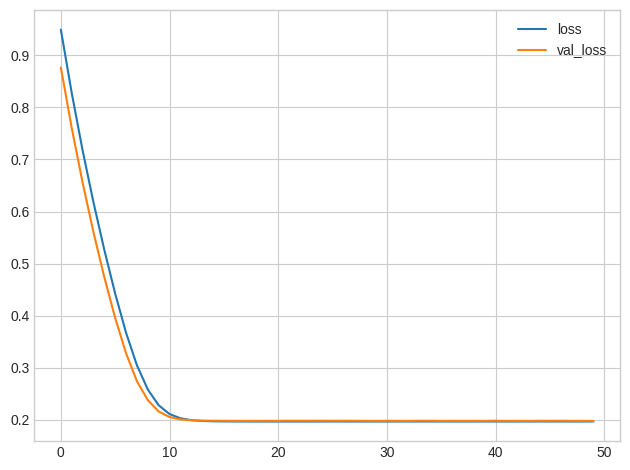

In [ ]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1974


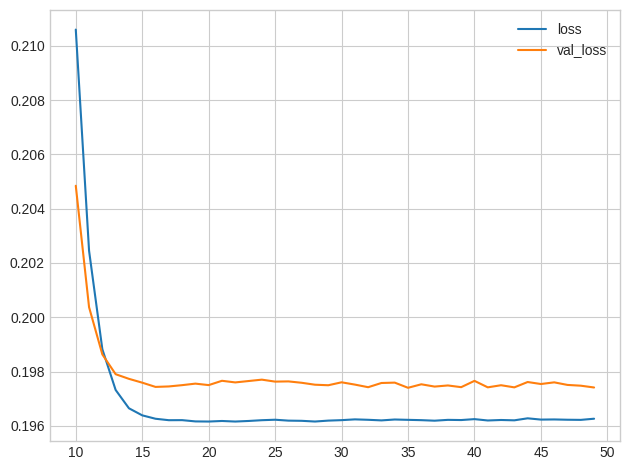

In [ ]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

What do you think? Would you say this model is underfitting, overfitting, just right?

Now let's add some capacity to our network. We'll add a couple of hidden layers with 192 units in all. Run the next cell to train the network and see the learning curves.

Epoch 1/50
48/48 [==============================] - 1s 7ms/step - loss: 0.2591 - val_loss: 0.2107
Epoch 2/50
48/48 [==============================] - 0s 6ms/step - loss: 0.2025 - val_loss: 0.2052
Epoch 3/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1968 - val_loss: 0.2024
Epoch 4/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1940 - val_loss: 0.2010
Epoch 5/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1915 - val_loss: 0.2022
Epoch 6/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1895 - val_loss: 0.1995
Epoch 7/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1885 - val_loss: 0.1985
Epoch 8/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1874 - val_loss: 0.1995
Epoch 9/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1867 - val_loss: 0.1980
Epoch 10/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1849 - val_loss: 0.2005
Epoch 11/50
48/48 [

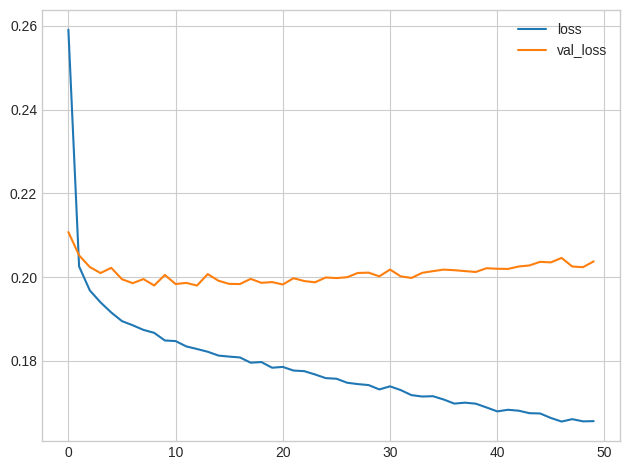

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

What is your evaluation of these curves? Underfitting, overfitting, just right?

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [ ]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)


Now run this cell to train the model and get the learning curves. Notice the callbacks argument in model.fit.

Epoch 1/50
48/48 [==============================] - 1s 7ms/step - loss: 0.2559 - val_loss: 0.2110
Epoch 2/50
48/48 [==============================] - 0s 5ms/step - loss: 0.2030 - val_loss: 0.2044
Epoch 3/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1968 - val_loss: 0.2016
Epoch 4/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1933 - val_loss: 0.2008
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1911 - val_loss: 0.2000
Epoch 6/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1897 - val_loss: 0.2002
Epoch 7/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1880 - val_loss: 0.1991
Epoch 8/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1867 - val_loss: 0.2017
Epoch 9/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1859 - val_loss: 0.1988
Epoch 10/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1846 - val_loss: 0.1990
Epoch 11/50
48/48 [

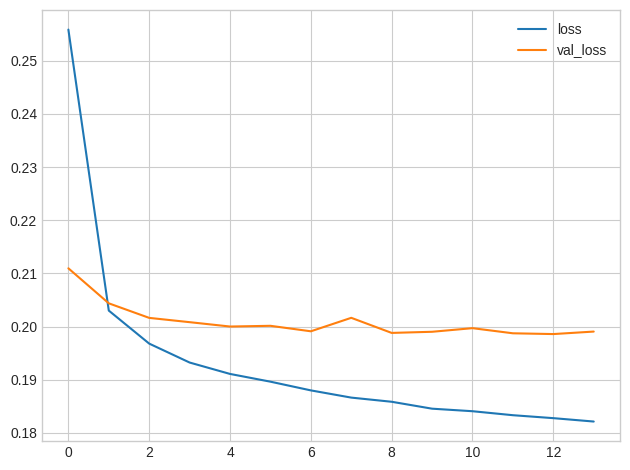

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Was this an improvement compared to training without early stopping?

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.

If you like, try experimenting with patience and min_delta to see what difference it might make.

**STOP HERE BEFORE CONTINUING**

Add two dropout layers, one after the Dense layer with 128 units, and one after the Dense layer with 64 units. Set the dropout rate on both to 0.3.

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

# Check your answer
q_1.check()

Now run this next cell to train the model see the effect of adding dropout.

In [ ]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Did adding dropout seem to help prevent overfitting this time?

Now, we'll switch topics to explore how batch normalization can fix problems in training.

Load the Concrete dataset. We won't do any standardization this time. This will make the effect of batch normalization much more apparent.

In [ ]:
concrete = pd.read_csv('https://raw.githubusercontent.com/raoulraft/Network-Intelligence-Course/main/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Run the following cell to train the network on the unstandardized Concrete data.

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Did you end up with a blank graph? Trying to train this network on this dataset will usually fail. Even when it does converge (due to a lucky weight initialization), it tends to converge to a very large number.

Batch normalization can help correct problems like this.

Add four BatchNormalization layers, one before each of the dense layers. (Remember to move the input_shape argument to the new first layer.)

In [ ]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Run the next cell to see if batch normalization will let us train the model.

In [ ]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Did adding batch normalization help?